<a href="https://colab.research.google.com/github/JuliaKoryukova/Neural-Networks/blob/main/09_%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BB%D0%B8%D1%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='green' size='7'>**Отработка методов transfer learning на задаче предсказания возраста**</font>  

**Датасет:**

https://www.kaggle.com/datasets/trainingdatapro/age-detection-human-faces-18-60-years/data


**Описание плана работы**

1. Выбор предобученной сверточной сети.
2. Адаптирование под задачу предсказания возраста по фото
3. Заморозка необходимой часть весов предобученной сети
4. Дообучение сети
5. Посчет метрик качества (accuracy)



# <font color='#11a642' size='6'> Импорт и установка библиотек

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from transformers import get_linear_schedule_with_warmup

# <font color='#11a642' size='6'> Загрузка и просмотр датасета

In [ ]:
# Загрузка датасета
!kaggle datasets download -d trainingdatapro/age-detection-human-faces-18-60-years

Dataset URL: https://www.kaggle.com/datasets/trainingdatapro/age-detection-human-faces-18-60-years
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 98% 329M/337M [00:03<00:00, 113MB/s]
100% 337M/337M [00:03<00:00, 108MB/s]


In [ ]:
# распаковка датасета
!unzip -q age-detection-human-faces-18-60-years.zip

In [ ]:
# Чтение датасета
df = pd.read_csv('/content/age_detection.csv')
df.head(4)

,file,age,split
0,train/18-20/0.jpg,18-20,train
1,train/18-20/1.jpg,18-20,train
2,train/18-20/2.jpg,18-20,train
3,train/18-20/3.jpg,18-20,train


In [ ]:
df.split.unique()

array(['train', 'test'], dtype=object)

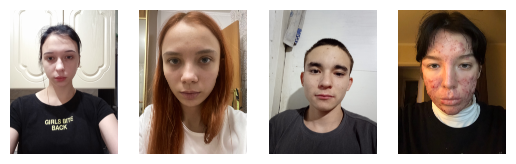

In [ ]:
# Просмотр изображений
for i in range(4):
    img_path = df.loc[i, 'file']
    img = Image.open(img_path)

    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# <font color='#11a642' size='6'> Подготовка данных

In [ ]:
img_dir = '/content/'

In [ ]:
# Разделение данных на train и test на основе столбца 'split'
train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

# Проверка размеров выборок
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 125, Test size: 25


In [ ]:
# Трансформации данных
train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(
            brightness=0.4,
            contrast=0.4,
            saturation=0.4),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
# Функция для загрузки изображений и меток
def load_data(dataframe, img_dir, transform):
    images = []
    labels = []

    for idx, row in dataframe.iterrows():
        img_path = os.path.join(img_dir, row['file']) # Полный путь к изображению
        if os.path.isfile(img_path): # Проверка есть ли файл
            image = Image.open(img_path).convert('RGB') # Открываю изображение
            if transform:
                image = transform(image) # Применяю аугментации
            images.append(image)
            labels.append(row['age']) # Добавляю метку возраста
        else:
            print(f"Файл не найден: {img_path}")
    print(f"Загружено изображений: {len(images)}, загружено меток: {len(labels)}")
    return images, labels

In [ ]:
# Загрузка train и test данных и применение к ним трансформаций
train_images, train_labels = load_data(train_df, img_dir, train_transforms)
test_images, test_labels = load_data(test_df, img_dir, test_transforms)

# Преобразование списков в тензоры
train_images = torch.stack(train_images)
train_labels = torch.tensor([int(label.split('-')[0]) for label in train_labels])
test_images = torch.stack(test_images)
test_labels = torch.tensor([int(label.split('-')[0]) for label in test_labels])

# loaders
train_loader = DataLoader(list(zip(train_images, train_labels)), batch_size=16, shuffle=True)
test_loader = DataLoader(list(zip(test_images, test_labels)), batch_size=16, shuffle=False)

# Проверка загрузки данных
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

Загружено изображений: 125, загружено меток: 125
Загружено изображений: 25, загружено меток: 25
torch.Size([16, 3, 224, 224]) torch.Size([16])


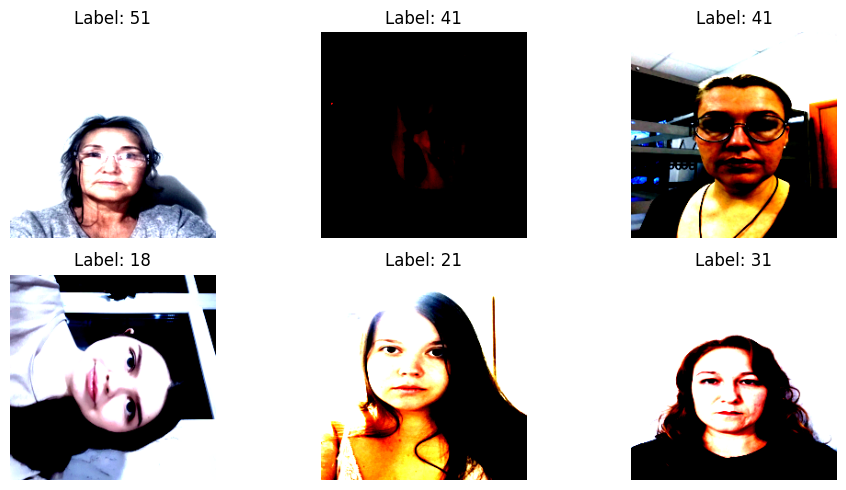

In [ ]:
# Отображение нескольких изображений и их меток
plt.figure(figsize=(10, 5))

# Получаем один батч из train_loader
images, labels = next(iter(train_loader))
num_images = min(len(images), 6)
for i in range(num_images):
    plt.subplot(2, 3, i + 1)

    # Преобразуем изображение в диапазон [0..1]
    img = images[i].permute(1, 2, 0)  # Переставляем оси для отображения
    img = img.clamp(0, 1)  # Ограничиваем значения в диапазоне [0..1]

    plt.imshow(img)
    plt.title(f'Label: {labels[i].item()}')  # Используем метку из того же батча
    plt.axis('off')

plt.tight_layout()
plt.show()

# <font color='#11a642' size='6'> Загрузка предобученной модели

In [ ]:
model = models.resnet152(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Заморозка всех слоев, кроме последнего
for param in model.parameters():
    param.requires_grad = False

# Разморозим последние два блока (layer4 и layer3)
for param in model.layer3.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True

# Разморозить последний fully connected слой (он уже разморожен, но на всякий случай)
for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
# Замена последнего fully connected слоя для задачи регрессии
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1) # Один выход для предсказания возраста

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# <font color='#11a642' size='6'> Дообучение модели

## <font color='#11a642' size='5'> Определение функции потерь (с label smoothing) и оптимизатора

In [ ]:
# Планировщик косинусного уменьшения скорости обучения с warmup
class WarmupCosineLingLR(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_epochs, max_epochs, max_lr, min_lr=0.0, last_epoch=-1):
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.max_lr = max_lr
        self.min_lr = min_lr
        super(WarmupCosineLingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch > self.warmup_epochs:
            # Линейное увеличение скорости обучения в течение warmup_epochs
            return [self.min_lr + (self.max_lr - self.min_lr) * (self.last_epoch / self.warmup_epochs) for _ in self.base_lrs]
        else:
            # Косинусное уменьшение скорости обучения
            cosine_decay = 0.5 * (1 + np.cos(np.pi * (self.last_epoch - self.warmup_epochs) / (self.max_epochs - self.warmup_epochs)))
            return [self.min_lr + (base_lr - self.min_lr) * cosine_decay for base_lr in self.base_lrs]

## <font color='#11a642' size='5'> Обучение модели

In [ ]:
def smooth_labels(labels, smoothing=0.1):
    num_classes = labels.size(1)
    smooth_label = (1 - smoothing) * labels + smoothing / num_classes
    return smooth_label

In [ ]:
# Функция для обучения
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0

        # Внутренний цикл по батчам с tqdm
        epoch_loader = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)

        for inputs, labels in epoch_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()  # Преобразуем метки в float для регрессии

            optimizer.zero_grad()

            # Прямой проход
            outputs = model(inputs)

            # Применение сглаживания меток
            labels_smooth = smooth_labels(labels.unsqueeze(1), smoothing=0.1)

            # Вычисление потерь
            loss = criterion(outputs, labels_smooth)

            # Обратное распространение
            loss.backward()

            # Градиентный клиппинг
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Обновление tqdm с потерями в реальном времени
            epoch_loader.set_postfix(Loss=loss.item())

        # Средняя потеря за эпоху
        epoch_loss = running_loss / len(train_loader.dataset)

        # Обновляем скорость обучения с помощью планировщика
        scheduler.step()

        # Выводим итоговую потерю через tqdm
        tqdm.write(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return model

In [ ]:
# Количество эпох обучения
n_epochs = 100

#  Скорость обучения
lr = 0.001

# Для регрессии используем MSE Loss
#criterion = nn.MSELoss()
#criterion = nn.SmoothL1Loss()
criterion = nn.HuberLoss()

# Оптимизатор для последних слоев
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

# Инициализирую планировщик
# scheduler = WarmupCosineLingLR(optimizer, warmup_epochs=5, max_epochs=n_epochs, max_lr=0.001, min_lr=lr)

# Инициализирую планировщик с разогревом
num_training_steps = len(train_loader) * n_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                             num_warmup_steps=5,
                                             num_training_steps=num_training_steps)

In [ ]:
model = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=n_epochs)

Epoch [1/100], Loss: 28.3273


Epoch [2/100], Loss: 27.1684


Epoch [3/100], Loss: 21.9936


Epoch [4/100], Loss: 14.7717


Epoch [5/100], Loss: 10.2668


Epoch [6/100], Loss: 8.1803


Epoch [7/100], Loss: 7.2722


Epoch [8/100], Loss: 6.1250


Epoch [9/100], Loss: 6.5471


Epoch [10/100], Loss: 5.2274


Epoch [11/100], Loss: 5.3287


Epoch [12/100], Loss: 5.5305


Epoch [13/100], Loss: 5.4475


Epoch [14/100], Loss: 5.0892


Epoch [15/100], Loss: 5.1768


Epoch [16/100], Loss: 5.2951


Epoch [17/100], Loss: 4.8441


Epoch [18/100], Loss: 4.9454


Epoch [19/100], Loss: 3.5827


Epoch [20/100], Loss: 3.5379


Epoch [21/100], Loss: 4.3039


Epoch [22/100], Loss: 3.7457


Epoch [23/100], Loss: 3.9079


Epoch [24/100], Loss: 3.8109


Epoch [25/100], Loss: 3.0820


Epoch [26/100], Loss: 3.2322


Epoch [27/100], Loss: 2.6857


Epoch [28/100], Loss: 2.6250


Epoch [29/100], Loss: 2.4101


Epoch [30/100], Loss: 3.0196


Epoch [31/100], Loss: 2.5864


Epoch [32/100], Loss: 2.3125


Epoch [33/100], Loss: 3.2241


Epoch [34/100], Loss: 2.4406


Epoch [35/100], Loss: 3.3651


Epoch [36/100], Loss: 2.4554


Epoch [37/100], Loss: 2.8021


Epoch [38/100], Loss: 2.4064


Epoch [39/100], Loss: 2.3783


Epoch [40/100], Loss: 2.2833


Epoch [41/100], Loss: 1.9173


Epoch [42/100], Loss: 1.6429


Epoch [43/100], Loss: 2.3107


Epoch [44/100], Loss: 1.6425


Epoch [45/100], Loss: 2.8555


Epoch [46/100], Loss: 1.9495


Epoch [47/100], Loss: 2.3242


Epoch [48/100], Loss: 2.3199


Epoch [49/100], Loss: 2.2489


Epoch [50/100], Loss: 1.9349


Epoch [51/100], Loss: 1.9825


Epoch [52/100], Loss: 1.8809


Epoch [53/100], Loss: 1.9994


Epoch [54/100], Loss: 1.8099


Epoch [55/100], Loss: 1.4935


Epoch [56/100], Loss: 1.0447


Epoch [57/100], Loss: 1.4395


Epoch [58/100], Loss: 1.7661


Epoch [59/100], Loss: 1.2093


Epoch [60/100], Loss: 2.3710


Epoch [61/100], Loss: 0.9765


Epoch [62/100], Loss: 1.8647


Epoch [63/100], Loss: 2.0459


Epoch [64/100], Loss: 1.1236


Epoch [65/100], Loss: 1.4941


Epoch [66/100], Loss: 2.1597


Epoch [67/100], Loss: 1.6591


Epoch [68/100], Loss: 0.9394


Epoch [69/100], Loss: 1.6263


Epoch [70/100], Loss: 1.3748


Epoch [71/100], Loss: 1.9914


Epoch [72/100], Loss: 1.2195


Epoch [73/100], Loss: 0.9451


Epoch [74/100], Loss: 1.0616


Epoch [75/100], Loss: 1.2930


Epoch [76/100], Loss: 1.7067


Epoch [77/100], Loss: 0.9160


Epoch [78/100], Loss: 1.5596


Epoch [79/100], Loss: 1.4812


Epoch [80/100], Loss: 1.2619


Epoch [81/100], Loss: 1.2820


Epoch [82/100], Loss: 0.9248


Epoch [83/100], Loss: 0.7168


Epoch [84/100], Loss: 0.7746


Epoch [85/100], Loss: 0.9428


Epoch [86/100], Loss: 0.9330


Epoch [87/100], Loss: 0.6845


Epoch [88/100], Loss: 0.7122


Epoch [89/100], Loss: 0.6934


Epoch [90/100], Loss: 0.8371


Epoch [91/100], Loss: 0.8729


Epoch [92/100], Loss: 0.7309


Epoch [93/100], Loss: 0.5820


Epoch [94/100], Loss: 0.6827


Epoch [95/100], Loss: 0.8322


Epoch [96/100], Loss: 0.6139


Epoch [97/100], Loss: 0.4424


Epoch [98/100], Loss: 0.5593


Epoch [99/100], Loss: 0.5114


Epoch [100/100], Loss: 0.6356


## <font color='#11a642' size='5'> Оценка модели на тестовом наборе

In [ ]:
# Возьму порог в 5 лет
def calculate_accuracy(predictions, labels, threshold=5):
    # Преобразуем предсказания и истинные значения в их исходные формы
    predictions = predictions.squeeze().cpu().numpy()
    labels = labels.cpu().numpy()

    # Считаем точность как долю предсказаний, отклонение которых от истины меньше порога
    correct = np.abs(predictions - labels) <= threshold
    accuracy = np.mean(correct) * 100
    return accuracy

In [ ]:
# Оценка модели на тестовом наборе
def evaluate_model(model, test_loader, threshold=5, device='cuda'):
    model.eval().to(device)
    running_loss = 0.0
    total_mae = 0.0
    correct_predictions = 0
    total_predictions = 0

    true_ages_list = []
    predicted_ages_list = []

    for images, true_ages in tqdm(test_loader):
        images = images.to(device)
        true_ages = true_ages.float().to(device)

        # Проверка на NaN в изображениях
        if torch.isnan(images).any():
            print("NaN найден в изображениях")

        with torch.no_grad():
            predicted_ages = model(images).squeeze(1)

            # Проверка на NaN в предсказаниях
            if torch.isnan(predicted_ages).any():
                print("NaN найден в предсказанных возрастах")

        # Подсчёт MAE
        mae = torch.abs(predicted_ages - true_ages).mean().item()
        total_mae += mae * images.size(0)

        # Подсчёт accuracy с порогом ±5 лет
        correct = (torch.abs(predicted_ages - true_ages) <= threshold).sum().item()
        correct_predictions += correct
        total_predictions += images.size(0)

        true_ages_list.extend(true_ages.cpu())
        predicted_ages_list.extend(predicted_ages.cpu())

    # Средняя абсолютная ошибка (MAE)
    mean_mae = total_mae / total_predictions
    overall_mae = mean_absolute_error(true_ages_list, predicted_ages_list)

    # Accuracy с порогом ±5 лет
    accuracy = correct_predictions / total_predictions

    return mean_mae, accuracy, overall_mae

In [ ]:
# Оценка модели на тестовых данных
mae, accuracy, overall_mae = evaluate_model(model, test_loader, threshold=5, device=device)

print(f"\nСредняя абсолютная ошибка (MAE): {mae:.4f}")
print(f"Accuracy (с порогом ±5 лет): {accuracy * 100:.2f}%")
print(f"Общая MAE: {overall_mae:.4f}")

100%|██████████| 2/2 [00:00<00:00, 10.49it/s]


Средняя абсолютная ошибка (MAE): 11.4563
Accuracy (с порогом ±5 лет): 44.00%
Общая MAE: 11.4563


## <font color='#11a642' size='5'>Проверка работы модели

In [ ]:
# Включаем модель в режим оценки
model.eval()

# Функция предсказания
def predict_age(image_path):
    # Загрузка изображения
    image = Image.open(image_path).convert('RGB')

    # Применение преобразования
    image = test_transforms(image).unsqueeze(0) # добавление размера батча

    # Проверка на наличие GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.to(device)

    # Получение предсказания
    with torch.no_grad():  # Выключаем градиенты
        output = model(image)

    # Извлекаем предсказанное значение возраста
    predicted_age = output.item()  # Получаем скалярное значение

    return predicted_age

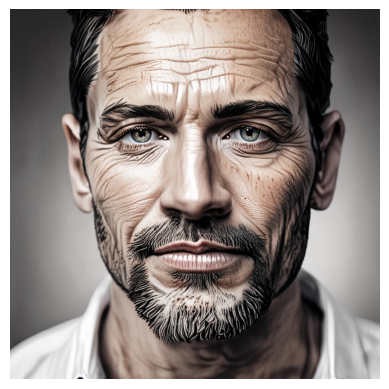

Предсказанный возраст: 34.76


In [ ]:
image_path = '/content/generated_image.png'

# Загрузка и отображение изображения
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  # Отключаем оси
plt.show()

# Предсказание возраста
predicted_age = predict_age(image_path)
print(f'Предсказанный возраст: {predicted_age:.2f}')